In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.utils import save_image

In [ ]:
# set the random seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
# Create a custom dataset that combines two images into one
class CombineDataset(datasets.MNIST):
    def __init__(self, root, train=True, transform=None, target_transform=None, download=False):
        super(CombineDataset, self).__init__(root, train, transform, target_transform, download)
        self.data, self.targets = self.combine_images(self.data, self.targets)

    def combine_images(self, data, targets):
        new_data = []
        new_targets = []

        # Combine two images in pairs
        for i in range(len(data) // 2):
            img1 = data[i].float()  # Ensure the data is converted to float for normalization
            img2 = data[i + 1].float()

            # Create a new empty image with combined width (28 height, 56 width)
            new_img = torch.zeros(1, 28, 56)

            # Normalize and combine images
            new_img[0, :, :28] = img1 / 255.0  # Normalize first image
            new_img[0, :, 28:] = img2 / 255.0  # Normalize second image

            new_data.append(new_img)

            # Combine targets for the new image pair
            new_targets.append(targets[i].item() * 10 + targets[i + 1].item())

        # Convert lists to tensors
        new_data = torch.stack(new_data)
        new_targets = torch.tensor(new_targets, dtype=torch.long)

        return new_data, new_targets

    def __getitem__(self, index):
        img, target = self.data[index], int(self.targets[index])

        # Apply transforms if available
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

    def __len__(self):
        return len(self.data)

# Create a Data Loader

In [ ]:
# Create the dataloader
batch_size = 128
train_dataset = CombineDataset(root="./data", train=True, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = CombineDataset(root="./data", train=False, download=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# Show the Samples from the Data Loader

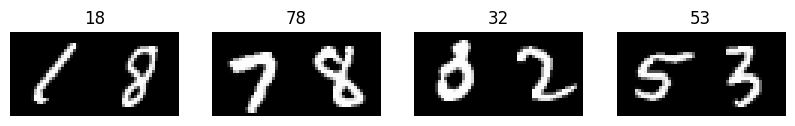

In [ ]:
# Show 4 samples from the dataloader
data_iter = iter(train_loader)
images, labels = next(data_iter)
fig, axs = plt.subplots(1, 4, figsize=(10, 10))
for i in range(4):
    axs[i].imshow(images[i].squeeze().numpy(), cmap="gray")
    axs[i].set_title(labels[i].item())
    axs[i].axis("off")
plt.show()

# Define a VAE model

In [ ]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        # Define the encoder
        self.encoder = nn.Sequential(
            nn.Linear(28 * 56, 400),
            nn.ReLU(),
            nn.Linear(400, 20)  # 10 for mean, 10 for log variance
        )
        # Define the decoder
        self.decoder = nn.Sequential(
            nn.Linear(10, 400),
            nn.ReLU(),
            nn.Linear(400, 28 * 56),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        return h[:, :10], h[:, 10:]  # mean, log variance

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 28 * 56))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Train VAE

In [ ]:
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, 28 * 56), reduction='sum')
    # KL divergence loss
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

vae = VAE()
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

train_losses = []
test_losses = []

num_epochs = 20

for epoch in range(num_epochs):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu')).view(-1, 28 * 56)
        optimizer.zero_grad()
        recon_batch, mu, logvar = vae(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    train_losses.append(train_loss / len(train_loader.dataset))

    # Test loop (optional)
    vae.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu')).view(-1, 28 * 56)
            recon_batch, mu, logvar = vae(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()

    test_losses.append(test_loss / len(test_loader.dataset))

    print(f'Epoch {epoch+1}, Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}')

Epoch 1, Train Loss: 401.3739, Test Loss: 319.6510
Epoch 2, Train Loss: 307.9035, Test Loss: 297.4648
Epoch 3, Train Loss: 293.8458, Test Loss: 289.0702
Epoch 4, Train Loss: 286.6728, Test Loss: 283.9928
Epoch 5, Train Loss: 281.9421, Test Loss: 280.0102
Epoch 6, Train Loss: 278.3890, Test Loss: 277.4503
Epoch 7, Train Loss: 275.5313, Test Loss: 275.3544
Epoch 8, Train Loss: 273.1676, Test Loss: 272.9700
Epoch 9, Train Loss: 271.2854, Test Loss: 271.8193
Epoch 10, Train Loss: 269.7000, Test Loss: 270.3978
Epoch 11, Train Loss: 268.2160, Test Loss: 269.9568
Epoch 12, Train Loss: 267.0063, Test Loss: 268.0871
Epoch 13, Train Loss: 265.8626, Test Loss: 267.8899
Epoch 14, Train Loss: 264.9064, Test Loss: 266.7456
Epoch 15, Train Loss: 264.0941, Test Loss: 265.9534
Epoch 16, Train Loss: 263.0581, Test Loss: 265.1157
Epoch 17, Train Loss: 262.1763, Test Loss: 264.6902
Epoch 18, Train Loss: 261.5036, Test Loss: 264.2873
Epoch 19, Train Loss: 260.7305, Test Loss: 263.6104
Epoch 20, Train Loss:

# Plot the training and testing loss

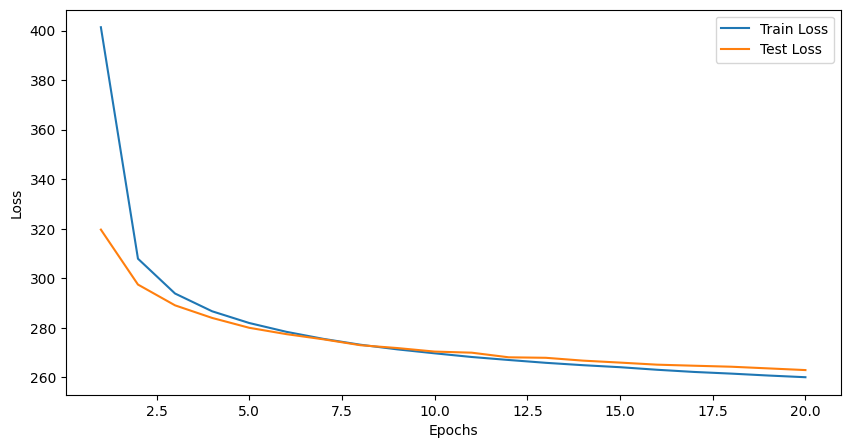

In [ ]:
# Plot the losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Generate Samples from VAE

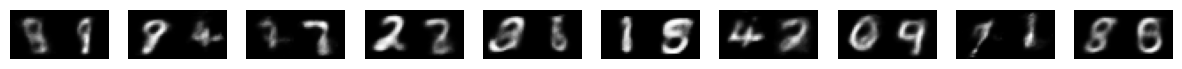

In [ ]:
vae.eval()
with torch.no_grad():
    z = torch.randn(10, 10).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))  # Sample 10 points in latent space
    samples = vae.decode(z).cpu()

    # Visualize the samples
    fig, axs = plt.subplots(1, 10, figsize=(15, 3))
    for i in range(10):
        axs[i].imshow(samples[i].view(28, 56).numpy(), cmap='gray')
        axs[i].axis('off')
    plt.show()